In [1]:
import tensorflow as tf
print(tf.config.list_physical_devices('GPU'))



[]


In [2]:
import tensorflow as tf
print(tf.__version__)



2.15.0


In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

C:\Users\chris\anaconda3\envs\ippr_skin\lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.5 when it was built against 1.14.6, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
BASE_DIR = "."          # notebook is inside HAM10000
IMAGE_DIR = "images"
METADATA_PATH = "ham10000_metadata.csv"

print(os.path.exists(IMAGE_DIR))
print(os.path.exists(METADATA_PATH))


True
True


In [3]:
metadata = pd.read_csv(METADATA_PATH)

print(metadata.shape)
print(metadata.columns)
metadata.head()



(11720, 16)
Index(['isic_id', 'attribution', 'copyright_license', 'age_approx',
       'anatom_site_general', 'anatom_site_special', 'concomitant_biopsy',
       'diagnosis_1', 'diagnosis_2', 'diagnosis_3', 'diagnosis_confirm_type',
       'image_manipulation', 'image_type', 'lesion_id', 'melanocytic', 'sex'],
      dtype='object')


,isic_id,attribution,copyright_license,age_approx,anatom_site_general,anatom_site_special,concomitant_biopsy,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_confirm_type,image_manipulation,image_type,lesion_id,melanocytic,sex
0,ISIC_0024306,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,45.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_7252831,True,male
1,ISIC_0024307,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,50.0,lower extremity,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_6125741,True,male
2,ISIC_0024308,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,55.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_3692653,True,female
3,ISIC_0024309,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,40.0,NaN,NaN,False,Benign,Benign melanocytic proliferations,Nevus,serial imaging showing no change,NaN,dermoscopic,IL_0959663,True,male
4,ISIC_0024310,"ViDIR Group, Department of Dermatology, Medica...",CC-BY-NC,60.0,anterior torso,NaN,True,Malignant,Malignant melanocytic proliferations (Melanoma),"Melanoma, NOS",histopathology,NaN,dermoscopic,IL_8194852,True,male


In [4]:
metadata["label"] = metadata["diagnosis_1"].apply(
    lambda x: 1 if str(x).lower() == "malignant" else 0
)

metadata["label"].value_counts()


label
0    9564
1    2156
Name: count, dtype: int64

In [5]:
metadata["filename"] = metadata["isic_id"] + ".jpg"

# sanity check
print(metadata["filename"].head())
print(os.path.exists(os.path.join(IMAGE_DIR, metadata["filename"].iloc[0])))



0    ISIC_0024306.jpg
1    ISIC_0024307.jpg
2    ISIC_0024308.jpg
3    ISIC_0024309.jpg
4    ISIC_0024310.jpg
Name: filename, dtype: object
True


In [6]:
train_df, val_df = train_test_split(
    metadata,
    test_size=0.2,
    stratify=metadata["label"],
    random_state=42
)

print(train_df.shape, val_df.shape)


(9376, 18) (2344, 18)


In [7]:
def preprocess_image(img):
    # Keras gives float32 image [0–255]
    img = img.astype(np.uint8)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (17,17))
    blackhat = cv2.morphologyEx(gray, cv2.MORPH_BLACKHAT, kernel)

    _, mask = cv2.threshold(blackhat, 10, 255, cv2.THRESH_BINARY)

    # Inpaint requires uint8
    img = cv2.inpaint(img, mask, 1, cv2.INPAINT_TELEA)

    img = img.astype(np.float32) / 255.0
    return img


In [8]:
datagen = ImageDataGenerator(
    rotation_range=20,
    horizontal_flip=True,
    zoom_range=0.15
)

train_gen = datagen.flow_from_dataframe(
    dataframe=train_df,
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="raw",
    shuffle=True,
    preprocessing_function=preprocess_image
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val_df,
    directory=IMAGE_DIR,
    x_col="filename",
    y_col="label",
    target_size=(224,224),
    batch_size=32,
    class_mode="raw",
    shuffle=False,
    preprocessing_function=preprocess_image
)


Found 9376 validated image filenames.
Found 2344 validated image filenames.


In [9]:
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.array([0,1]),
    y=train_df["label"]
)

class_weights = dict(enumerate(class_weights))
class_weights


{0: 0.6127303620441772, 1: 2.7176811594202896}

In [10]:
base_model = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(224,224,3)
)

base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

In [ ]:
history = model.fit(
    
    train_gen,
    validation_data=val_gen,
    epochs=10,
    class_weight=class_weights
)


Epoch 1/10


 64/293 [=====>........................] - ETA: 5:43 - loss: 0.7334 - accuracy: 0.5776

In [23]:
val_preds = model.predict(val_gen)
val_preds = (val_preds > 0.5).astype(int)

print(classification_report(val_df["label"], val_preds))
print(confusion_matrix(val_df["label"], val_preds))


74/74 [==============================] - 78s 1s/step
              precision    recall  f1-score   support

           0       0.94      0.72      0.81      1913
           1       0.39      0.79      0.52       431

    accuracy                           0.73      2344
   macro avg       0.66      0.75      0.67      2344
weighted avg       0.84      0.73      0.76      2344

[[1371  542]
 [  91  340]]


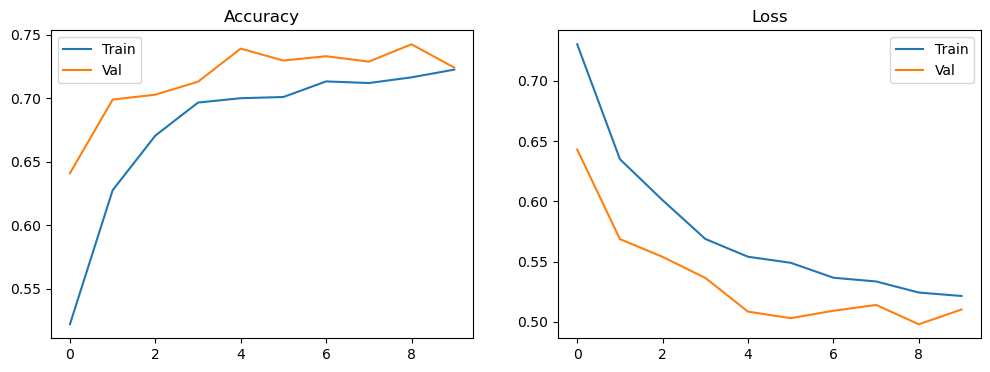

In [25]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1)
plt.plot(history.history["accuracy"], label="Train")
plt.plot(history.history["val_accuracy"], label="Val")
plt.title("Accuracy")
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history["loss"], label="Train")
plt.plot(history.history["val_loss"], label="Val")
plt.title("Loss")
plt.legend()

plt.show()


1/1 [==============================] - 3s 3s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
C:\Users\chris\AppData\Local\Temp\ipykernel_21472\2833417117.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.title(f"True: {int(labels[i])}, Pred: {int(preds[i]>0.5)}")
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [2.0131347..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [51.006683..241.36838].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [24.854006..254.83353].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats 

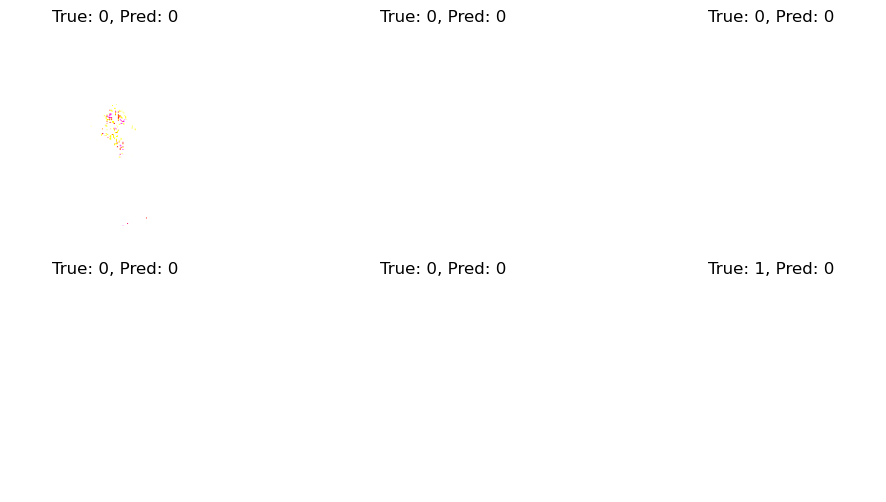

In [27]:
sample_batch = next(val_gen)
images, labels = sample_batch

preds = model.predict(images)

plt.figure(figsize=(12,6))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.title(f"True: {int(labels[i])}, Pred: {int(preds[i]>0.5)}")
    plt.axis("off")
plt.show()


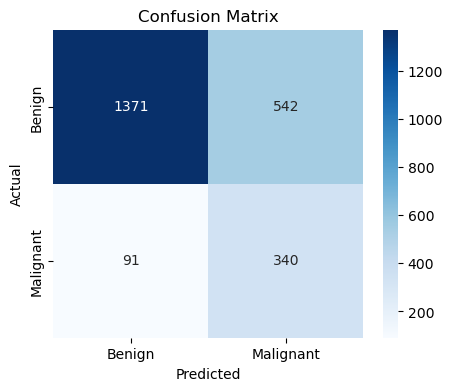

In [29]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(val_df["label"], val_preds)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Benign","Malignant"],
            yticklabels=["Benign","Malignant"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


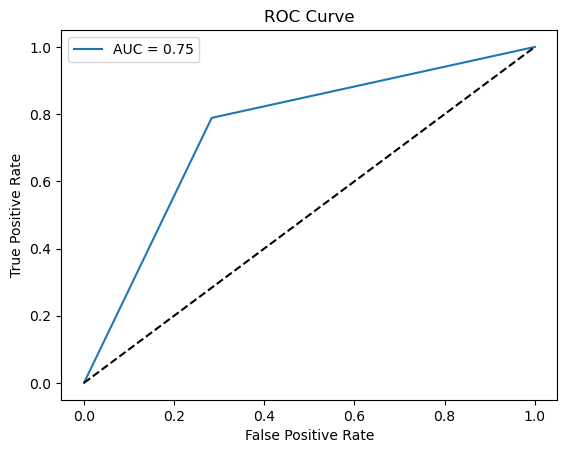

In [31]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(val_df["label"], val_preds)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.2f}")
plt.plot([0,1],[0,1],'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


1/1 [==============================] - 1s 596ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..230.89818].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [46.14726..254.44505].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [59.75767..254.46004].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [15.63613..233.32672].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [9.2339115..209.92326].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [21.0..175.79164].


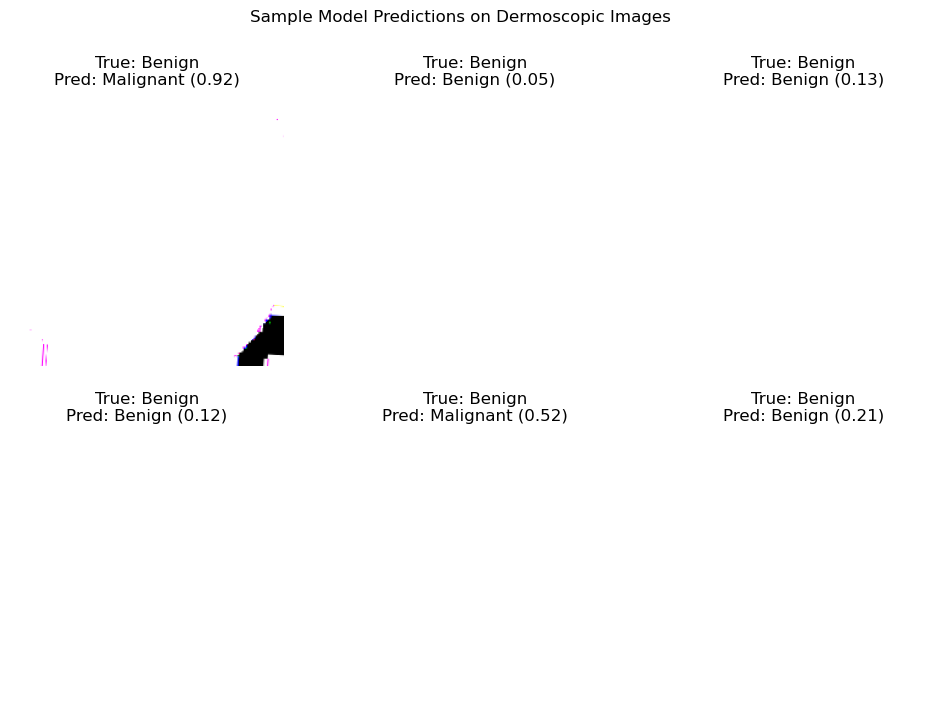

In [33]:
import matplotlib.pyplot as plt
import numpy as np

sample_batch = next(val_gen)
images, labels = sample_batch
preds = model.predict(images)

plt.figure(figsize=(12,8))

for i in range(6):
    plt.subplot(2,3,i+1)
    plt.imshow(images[i])
    plt.axis("off")
    plt.title(
        f"True: {'Malignant' if labels[i]==1 else 'Benign'}\n"
        f"Pred: {'Malignant' if preds[i]>0.5 else 'Benign'} "
        f"({preds[i][0]:.2f})"
    )

plt.suptitle("Sample Model Predictions on Dermoscopic Images")
plt.show()


In [35]:
val_loss, val_accuracy = model.evaluate(val_gen)
print("Validation Accuracy:", round(val_accuracy * 100, 2), "%")


74/74 [==============================] - 75s 1s/step - loss: 0.5100 - accuracy: 0.7312
Validation Accuracy: 73.12 %


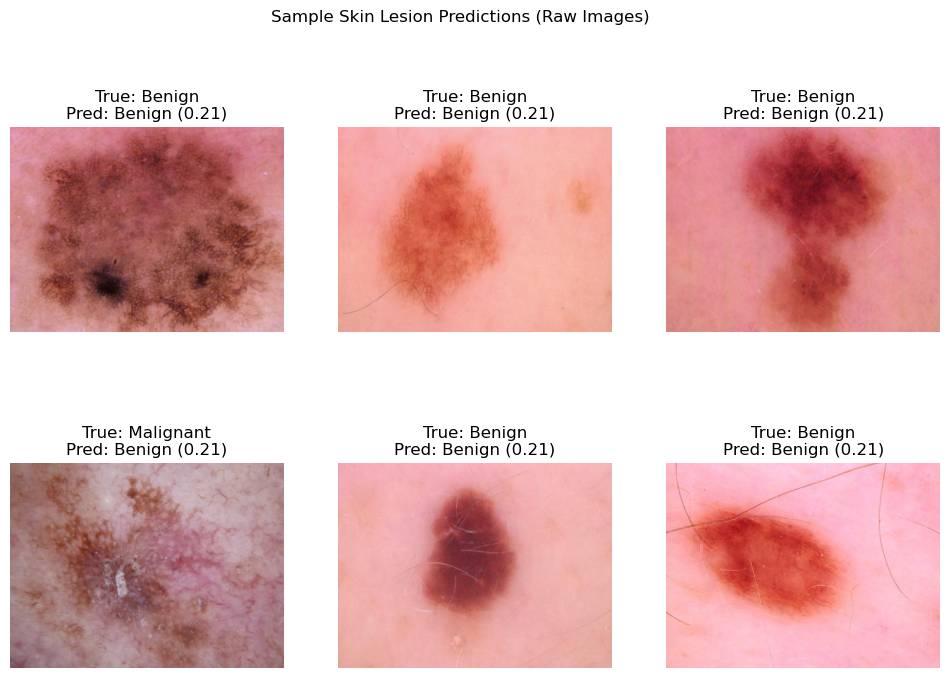

In [39]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os

SAMPLES = 6
sample_df = val_df.sample(SAMPLES, random_state=42)

plt.figure(figsize=(12,8))

for i, row in enumerate(sample_df.itertuples()):
    img_path = os.path.join(IMAGE_DIR, row.filename)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    img_resized = cv2.resize(img, (224,224))
    img_norm = img_resized / 255.0

    pred = model.predict(
        np.expand_dims(img_norm, axis=0),
        verbose=0
    )[0][0]

    plt.subplot(2,3,i+1)
    plt.imshow(img)
    plt.axis("off")
    plt.title(
        f"True: {'Malignant' if row.label==1 else 'Benign'}\n"
        f"Pred: {'Malignant' if pred>0.5 else 'Benign'} ({pred:.2f})"
    )

plt.suptitle("Sample Skin Lesion Predictions (Raw Images)")
plt.show()


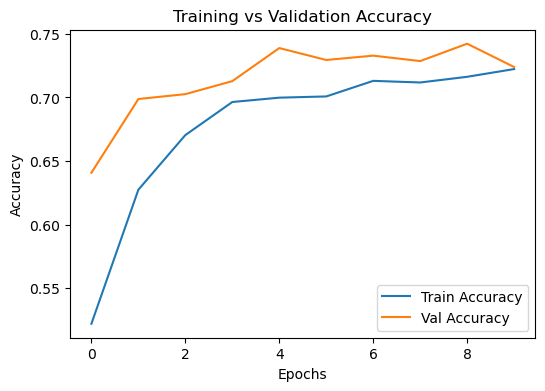

In [41]:
plt.figure(figsize=(6,4))
plt.plot(history.history["accuracy"], label="Train Accuracy")
plt.plot(history.history["val_accuracy"], label="Val Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training vs Validation Accuracy")
plt.show()


In [43]:
model.save("skin_cancer_model.keras")
